# 📌 Project Overview

This project aims to predict whether a person is likely to have diabetes based on medical features such as glucose level, blood pressure, BMI, and age. We'll use a logistic regression model.

## 📂 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

## 📊 Load and Explore the Data

In [3]:
data = pd.read_csv("data/diabetes.csv")
df = data.copy()
df.head(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [9]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## 📈 Exploratory Data Analysis (EDA)

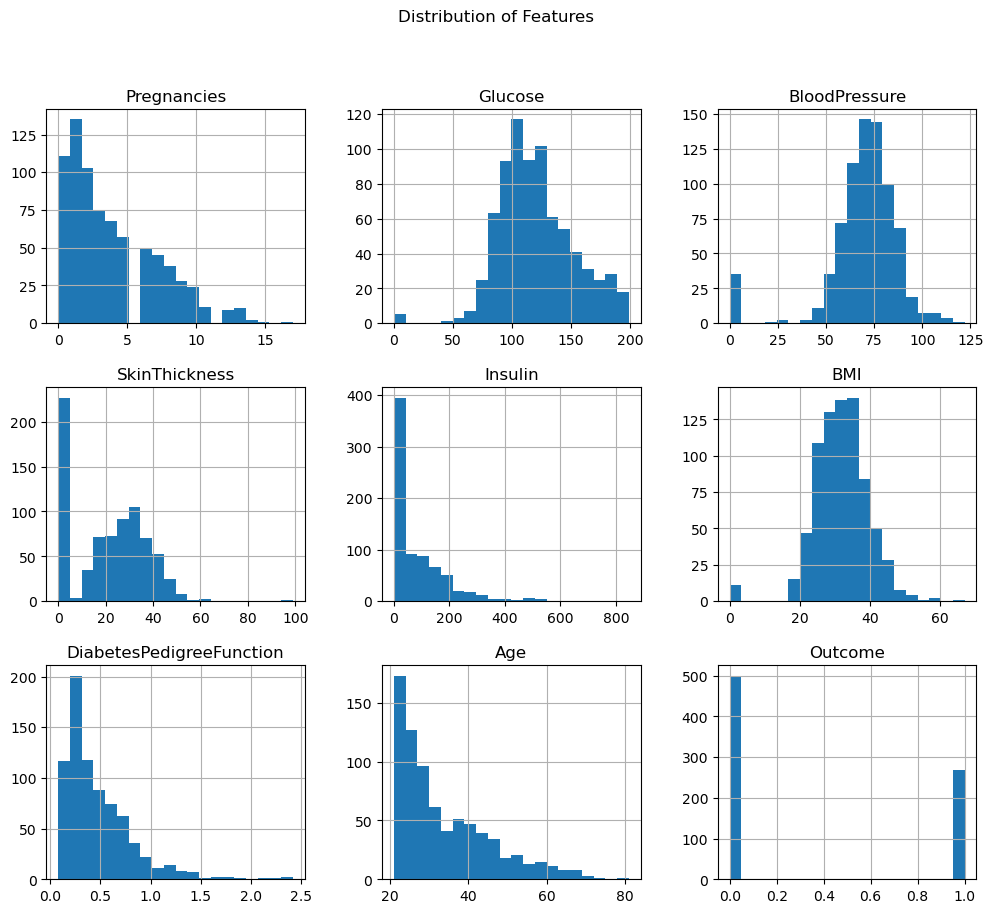

In [11]:
#Plotting histograms for all numerical features
df.hist(bins=20, figsize=(12, 10))
plt.suptitle('Distribution of Features')
plt.show()

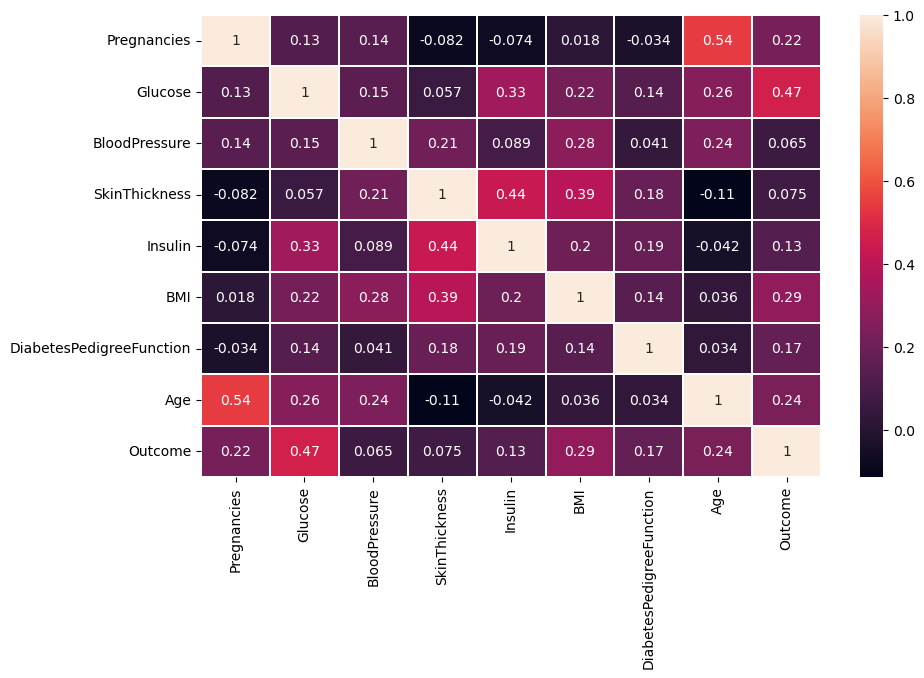

In [13]:
#Correlations of the variables
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(),annot=True, linewidths=0.1)
plt.show()

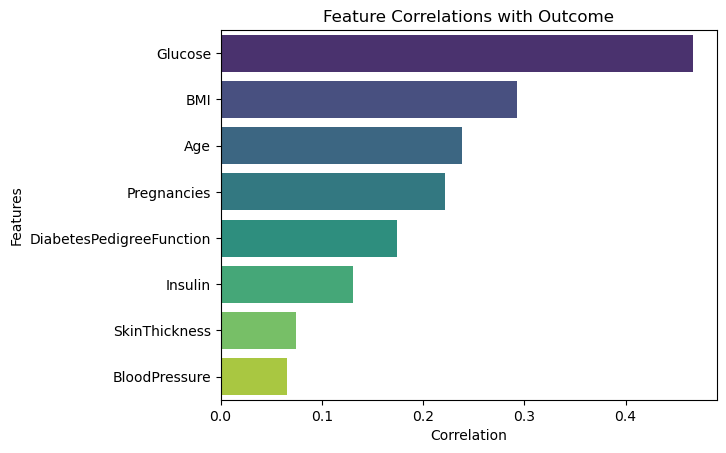

In [15]:
#Correlation with the target variable (Outcome)
correlations = df.corr()['Outcome'].sort_values(ascending=False)[1:]
sns.barplot(x = correlations.values, y = correlations.index, palette = 'viridis')
plt.title('Feature Correlations with Outcome')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.show()

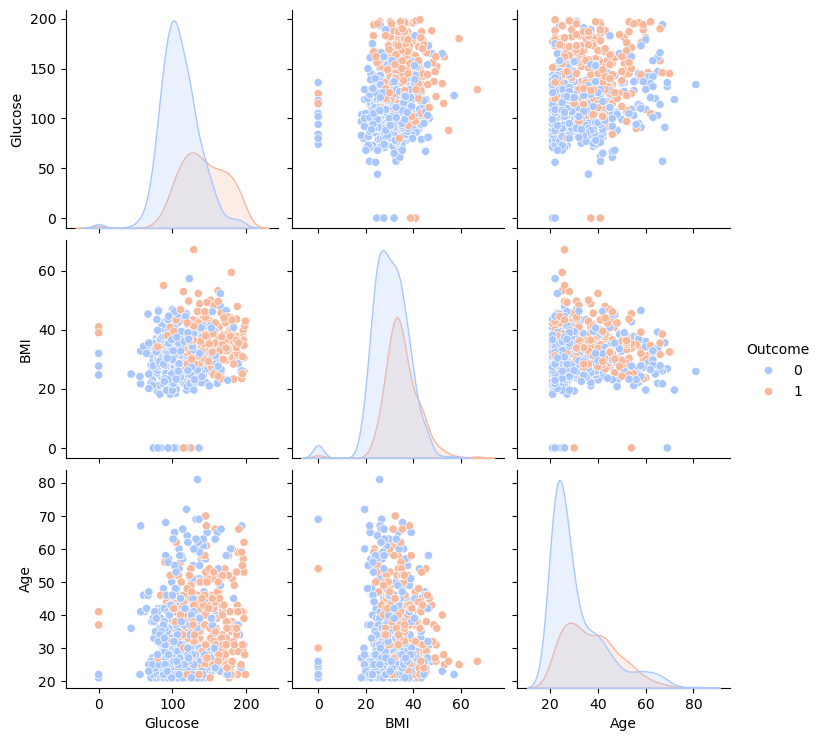

In [17]:
#Distribution by outcome (0 = no diabetes, 1 = diabetes)
sns.pairplot(df[['Glucose', 'BMI', 'Age', "Outcome"]], hue='Outcome', palette='coolwarm');

## 🧹 Data Cleaning

In [19]:
df[df.Glucose < 50]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
62,5,44,62,0,0,25.0,0.587,36,0
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


Glucose value cannot be 0, invalid data.

We will set these values as NaN and use KNN to impute them.

In [21]:
df.Glucose.replace(0,np.NaN, inplace=True)

In [23]:
df[df.BMI < 10]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125.0,96,0,0,0.0,0.232,54,1
49,7,105.0,0,0,0,0.0,0.305,24,0
60,2,84.0,0,0,0,0.0,0.304,21,0
81,2,74.0,0,0,0,0.0,0.102,22,0
145,0,102.0,75,23,0,0.0,0.572,21,0
371,0,118.0,64,23,89,0.0,1.731,21,0
426,0,94.0,0,0,0,0.0,0.256,25,0
494,3,80.0,0,0,0,0.0,0.174,22,0
522,6,114.0,0,0,0,0.0,0.189,26,0
684,5,136.0,82,0,0,0.0,0.640,69,0


BMI value cannot be 0, invalid data.

In [25]:
df.BMI.replace(0,np.NaN, inplace=True)

In [27]:
df[df.Insulin == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35,0,33.6,0.627,50,1
1,1,85.0,66,29,0,26.6,0.351,31,0
2,8,183.0,64,0,0,23.3,0.672,32,1
5,5,116.0,74,0,0,25.6,0.201,30,0
7,10,115.0,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170.0,74,31,0,44.0,0.403,43,1
762,9,89.0,62,0,0,22.5,0.142,33,0
764,2,122.0,70,27,0,36.8,0.340,27,0
766,1,126.0,60,0,0,30.1,0.349,47,1


Insulin value cannot be 0, invalid data.

In [29]:
#There are too many missing values.
df = df.drop("Insulin", axis=1)

In [31]:
df[(df.SkinThickness == 0) | (df.SkinThickness > 80)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183.0,64,0,23.3,0.672,32,1
5,5,116.0,74,0,25.6,0.201,30,0
7,10,115.0,0,0,35.3,0.134,29,0
9,8,125.0,96,0,NaN,0.232,54,1
10,4,110.0,92,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...
757,0,123.0,72,0,36.3,0.258,52,1
758,1,106.0,76,0,37.5,0.197,26,0
759,6,190.0,92,0,35.5,0.278,66,1
762,9,89.0,62,0,22.5,0.142,33,0


SkinThickness value cannot be 0, invalid data.

In [33]:
#There are too many missing values.
df = df.drop("SkinThickness", axis=1)

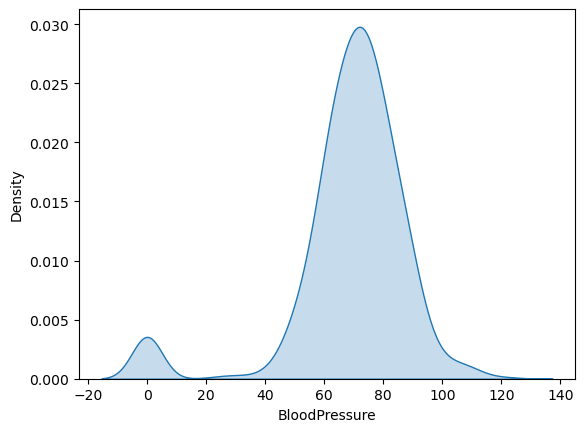

In [35]:
sns.kdeplot(df.BloodPressure, fill=True);

In [37]:
df[df.BloodPressure == 0]

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115.0,0,35.3,0.134,29,0
15,7,100.0,0,30.0,0.484,32,1
49,7,105.0,0,NaN,0.305,24,0
60,2,84.0,0,NaN,0.304,21,0
78,0,131.0,0,43.2,0.270,26,1
81,2,74.0,0,NaN,0.102,22,0
172,2,87.0,0,28.9,0.773,25,0
193,11,135.0,0,52.3,0.578,40,1
222,7,119.0,0,25.2,0.209,37,0
261,3,141.0,0,30.0,0.761,27,1


BloodPressure value cannot be 0, invalid data.

In [39]:
df.BloodPressure.replace(0,np.NaN, inplace=True)

In [41]:
df.isna().sum()

Pregnancies                  0
Glucose                      5
BloodPressure               35
BMI                         11
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64

In [43]:
#Imputing missing values with KNNImputer.
imputer = KNNImputer(n_neighbors = 3)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
df.head(4)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,28.1,0.167,21.0,0.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   BMI                       768 non-null    float64
 4   DiabetesPedigreeFunction  768 non-null    float64
 5   Age                       768 non-null    float64
 6   Outcome                   768 non-null    float64
dtypes: float64(7)
memory usage: 42.1 KB


All variables became float. We will revert them to their original types.

In [47]:
#Converting all variables to integers except for the two variables that are originally float.
exclude_columns = ['BMI', 'DiabetesPedigreeFunction']
df = df.apply(lambda x: x.astype('int64') if x.name not in exclude_columns else x)
df.head(4)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,33.6,0.627,50,1
1,1,85,66,26.6,0.351,31,0
2,8,183,64,23.3,0.672,32,1
3,1,89,66,28.1,0.167,21,0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   BMI                       768 non-null    float64
 4   DiabetesPedigreeFunction  768 non-null    float64
 5   Age                       768 non-null    int64  
 6   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 42.1 KB


In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.587240,30.514710,44.000,99.00000,117.0000,141.00000,199.00
BloodPressure,768.0,72.328125,12.217889,24.000,64.00000,72.0000,80.00000,122.00
BMI,768.0,32.432682,6.885407,18.200,27.50000,32.1500,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


The data is ready for machine learning 🚀

In [53]:
#Saving the preprocessed data.
df.to_csv("data/diabetes_preprocessed.csv", index_label = False)

## 🤖 Model Building

In [55]:
X = df.drop("Outcome", axis=1)
y = df.Outcome
X.head(4)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,33.6,0.627,50
1,1,85,66,26.6,0.351,31
2,8,183,64,23.3,0.672,32
3,1,89,66,28.1,0.167,21


In [57]:
#scaling
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled.head(4)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866139,-0.026874,0.169646,0.468492,1.425995
1,-0.844885,-1.199785,-0.518277,-0.847660,-0.365061,-0.190672
2,1.233880,2.013874,-0.682078,-1.327247,0.604397,-0.105584
3,-0.844885,-1.068615,-0.518277,-0.629666,-0.920763,-1.041549


In [59]:
#saving the fitted scaler along with the columns
columns = X.columns.tolist()
joblib.dump((scaler,columns), "models/scaler_with_columns.pkl")  

['models/scaler_with_columns.pkl']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20, random_state = 42) 

In [63]:
#Building the model and evaluation
loj_model = LogisticRegression()
loj_model.fit(X_train, y_train)

y_pred = loj_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.75325


In [65]:
#cross validation
accuracy_cv = cross_val_score(loj_model, X_train, y_train, cv = 10, scoring = 'accuracy').mean()       
print(f"Validated accuracy: {accuracy_cv:.5f}")

Validated accuracy: 0.76872


## 🔧 Hyperparameter Tuning

In [67]:
#Since penalty types are not compatible with all solvers, I created the grid in this way.
param_grid = [
    {'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 500]},
    {'penalty': ['l1'], 'solver': ['liblinear'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 500]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 500], 'l1_ratio': [0.5, 0.4, 0.6]}
]

In [69]:
grid_search = GridSearchCV(estimator = loj_model,           
                           param_grid = param_grid,         
                           cv = 10,            
                           scoring = 'accuracy',            
                           verbose = 2,             
                           n_jobs = -1)              

In [71]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 200, 500], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 200, 500], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.5, 0.4, 0.6],
                          'max_iter': [100, 200, 500],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='accuracy', verbose=2)

In [73]:
#The most optimal values.
print(grid_search.best_params_["C"])
print(grid_search.best_params_["penalty"])
print(grid_search.best_params_["solver"])
print(grid_search.best_params_["max_iter"])

0.01
l2
liblinear
100


In [75]:
best_c = grid_search.best_params_["C"]
best_p = grid_search.best_params_["penalty"]
best_s = grid_search.best_params_["solver"]
best_mi = grid_search.best_params_["max_iter"]

In [77]:
#building the final model 
loj_final_model = LogisticRegression(C = best_c,
                                     penalty = best_p,
                                     solver = best_s,
                                     max_iter = best_mi)   
loj_final_model.fit(X_train, y_train)

y_pred_final = loj_final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"Accuracy: {accuracy_final:.5f}")

Accuracy: 0.74675


In [79]:
#cross validation
accuracy_cv_final = cross_val_score(loj_final_model, X_train, y_train, cv = 10, scoring = 'accuracy').mean()       
print(f"Validated accuracy: {accuracy_cv_final:.5f}")

Validated accuracy: 0.77028


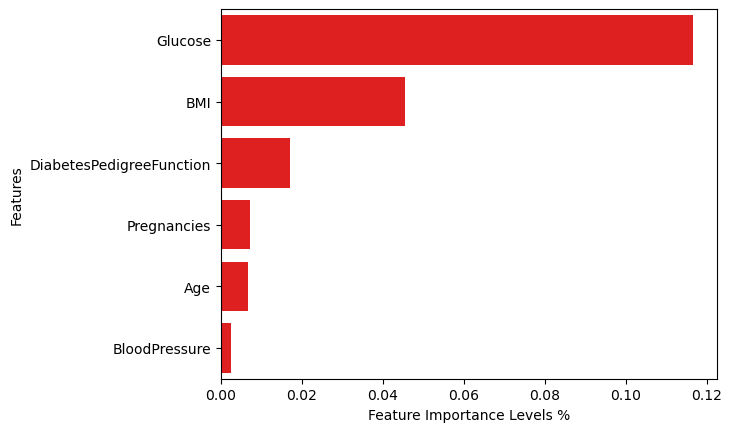

In [81]:
#Feature importance analysis using permutation importance.
result = permutation_importance(loj_final_model, X_train, y_train, n_repeats = 10, random_state = 42)           

#Creating a dataframe for visualization.
importance_df = pd.DataFrame({            
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values(by = "Importance", ascending = False)

#visualization
sns.barplot(x = "Importance", y = "Feature", data = importance_df, color = "red");          
plt.xlabel("Feature Importance Levels %");
plt.ylabel("Features");

In [83]:
#Saving the final model.
joblib.dump(loj_final_model, "models/loj_final_model.pkl") 

['models/loj_final_model.pkl']

## ✅ Conclusion

In this project, we built a classification model to predict whether a person has diabetes based on clinical data.

🔍 **Key Steps Taken**:

- Conducted Exploratory Data Analysis (EDA) to understand feature distributions and correlations.
- Invalid values were replaced with NaN, and the data was cleaned by applying imputation to the missing values.
- Built a logistic regression model using scikit-learn and evaluated its performance using accuracy.
- Hiperparameter tuning was applied, and the final model was built with the obtained values.

📊 **Model Performance**:

- The model achieved an accuracy of approximately 77% on the test data.- Glucose level was found to be the most influential feature through permutation importance analysis.

🔁 **Future Improvements**:

- Try more complex models (e.g., Random Forest, XGBoost)
- Apply feature engineering.

The model provides a good starting point for diabetes prediction and can be improved further with more advanced techniques and more data.
.
